# COVID-19 Healthcare Capacity in Orange County, CA

## 1. Import Libraries

The libraries I will be using are: Pandas, NumPy, JSON, GeoPy, Matplotlib, Skikit-learn, and Folium.

In [1]:
import pandas as pd
import numpy as np
import json
!pip install geocoder
import geocoder as geocoder
!pip install geopy
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
!pip install folium
import folium

print ('Libraries imported')

     |████████████████████████████████| 102kB 17.1MB/s ta 0:00:01
     |████████████████████████████████| 92kB 7.8MB/s eta 0:00:011
Libraries imported


## 2. Build Dataframe

The Orange County government website archives COVID-19 statistics data. I use Pandas instand of Beautifulsoup to scrape data because Pandas has easier coding. The data contains the name of cities in Orange County, populations and total COVID-19 cases in each city. We will use these datasets later.

In [40]:
data = pd.read_html('https://occovid19.ochealthinfo.com/coronavirus-in-oc')
 
for df in data:
    if(str(np.array_equal(np.array(df),np.array(df)))=="True"): 
        df = pd.DataFrame(df)    
    break

df.columns = ['City', 'Population', 'Total Cases']
df = df[1:-3]
df.head()

,City,Population,Total Cases
1,Aliso Viejo,51372,18
2,Anaheim,359339,316
3,Brea,45606,20
4,Buena Park,83384,76
5,Costa Mesa,115830,38


In [41]:
# Drop Population Column and reindex dataframe

df.drop('Population', axis = 1, inplace = True)
df = df.reset_index(drop = True)
df.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,City,Total Cases
0,Aliso Viejo,18
1,Anaheim,316
2,Brea,20
3,Buena Park,76
4,Costa Mesa,38


## 3. Get City Coordinates

I use Geocoder to find geographic locations for the obtained cities above. This process will give me latitudes and longitudes for each city in Orange County.

In [9]:
def getLatLong(row):
    lat_lng_coords = None
    search_query = '{}, California,USA'.format(row)
    try:
        while(lat_lng_coords is None):
            g = geocoder.arcgis(search_query)
            lat_lng_coords = g.latlng
    except IndexError:
        latitude = 0.0
        longitude = 0.0
        print('BACKUP')
        return [latitude,longitude]

    latitude = lat_lng_coords[0]
    longitude = lat_lng_coords[1]
    print(latitude, longitude)
    return [latitude, longitude]

coords_list = df['City'].apply(getLatLong).tolist()

33.56964000000005 -117.72690999999998
33.83286000000004 -117.91523999999998
33.917590000000075 -117.88898999999998
33.86520000000007 -117.99803999999995
33.66389000000004 -117.90238999999997
33.63404000000003 -117.58623999999998
33.82434000000006 -118.03722999999997
33.480540000000076 -117.69764999999995
33.709070000000054 -117.95027999999996
33.870330000000024 -117.92895999999996
33.77607000000006 -117.93610999999999
33.67893000000004 -118.00156999999996
33.68730000000005 -117.82590999999996
33.93187000000006 -117.94347999999997
33.84847000000008 -118.03726999999998
33.570460000000026 -117.63926999999995
33.54536000000007 -117.78152999999998
33.601860000000045 -117.69094999999999
33.56065000000007 -117.70821999999998
33.61256000000003 -117.71871999999996
33.62825000000004 -117.71742999999998
33.80316000000005 -118.07661999999999
33.74469000000005 -117.98646999999994
33.620070000000055 -117.67708999999996
33.61703000000006 -117.93032999999997
33.787870000000055 -117.85070999999999
33.8

In [42]:
df[['City Latitude', 'City Longitude']] = pd.DataFrame(coords_list, columns = ['Latitude', 'Longitude'])
df

,City,Total Cases,City Latitude,City Longitude
0,Aliso Viejo,18,33.56964,-117.72691
1,Anaheim,316,33.83286,-117.91524
2,Brea,20,33.91759,-117.88899
3,Buena Park,76,33.86520,-117.99804
4,Costa Mesa,38,33.66389,-117.90239
5,Coto de Caza,5,33.63404,-117.58624
6,Cypress,42,33.82434,-118.03723
7,Dana Point,23,33.48054,-117.69765
8,Fountain Valley,31,33.70907,-117.95028
9,Fullerton,74,33.87033,-117.92896


## 4. Binning the COVID-19 Cases

Let's visualize the total cases in each city by deploying bar graph. Then we devide the data into four bins:
1. Low Risk: 5~82 cases
2. Medium Risk: 82~159 cases
3. High Risk: 159~236 cases
4. Extreme High Risk: 236~313 cases

In [11]:
# Change the "Total Cases" column type from object to integer
df["Total Cases"] = df["Total Cases"].astype(str).astype(int)

# Generate 5 pins by categorizing total cases
bins = np.linspace(min(df["Total Cases"]), max(df["Total Cases"]), 5)
bins

array([  5.  ,  86.25, 167.5 , 248.75, 330.  ])

In [12]:
group_names = ['Low Risk', 'Medium Risk', 'High Risk', 'Extreme High Risk']
df['Risk Level'] = pd.cut(df['Total Cases'], bins, labels=group_names, include_lowest=True )
df.head()

,City,Total Cases,Latitude,Longitude,Risk Level
0,Aliso Viejo,18,33.56964,-117.72691,Low Risk
1,Anaheim,316,33.83286,-117.91524,Extreme High Risk
2,Brea,20,33.91759,-117.88899,Low Risk
3,Buena Park,76,33.86520,-117.99804,Low Risk
4,Costa Mesa,38,33.66389,-117.90239,Low Risk


In [13]:
# Lets examine the number of cities falls into each bin
print(df["Risk Level"].value_counts())

Low Risk             33
Medium Risk           3
Extreme High Risk     2
High Risk             1
Name: Risk Level, dtype: int64


## 5. Visualize the Bins

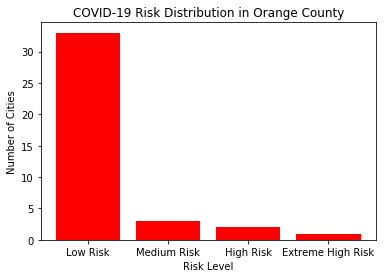

In [15]:
# Create bar chart to visualize the risk distributions in Orange County
%matplotlib inline
import matplotlib as plt
from matplotlib import pyplot

pyplot.bar(group_names, df["Risk Level"].value_counts(), color = 'r')

plt.pyplot.title('COVID-19 Risk Distribution in Orange County') 
plt.pyplot.ylabel('Number of Cities')
plt.pyplot.xlabel('Risk Level') 

plt.pyplot.show()

## 6. Identify Local Hospitals Using Foursqure

Next, by using Foursqure API, we will be able to collect local hospitals geographic information.

In [19]:
CLIENT_ID = 'K25YJQ3E34V2MXHR20RADQP2RRXKMG3MFBH0EOQXDWPTWIEF'
CLIENT_SECRET = 'PIYHI0QKR0DN3S5ZECN541RABQYUPI4NBWODEH1NMMTIW1IL' 
VERSION = '20180604'
LIMIT = 100

# I choose Irvine as center , and find hospitals within 5000 meters radius. 

irvine_lat = 33.6846
irvine_lng = -117.8265
search_query = 'Hospital'
radius = 5000

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    irvine_lat, 
    irvine_lng, 
    VERSION, 
    search_query, 
    radius, 
    LIMIT)
url

results_irvine = requests.get(url).json()
results_irvine

{'meta': {'code': 200, 'requestId': '5eaa4d491835dd05ebd57cfe'},
 'response': {'venues': [{'id': '4c35f5c37cc0c9b6c6c0f59a',
    'name': 'Hoag Hospital Irvine',
    'location': {'address': '16200 Sand Canyon Ave',
     'crossStreet': 'Alton',
     'lat': 33.6608041,
     'lng': -117.7724516,
     'labeledLatLngs': [{'label': 'display',
       'lat': 33.6608041,
       'lng': -117.7724516}],
     'distance': 5664,
     'postalCode': '92618',
     'cc': 'US',
     'city': 'Irvine',
     'state': 'CA',
     'country': 'United States',
     'formattedAddress': ['16200 Sand Canyon Ave (Alton)',
      'Irvine, CA 92618',
      'United States']},
    'categories': [{'id': '4bf58dd8d48988d196941735',
      'name': 'Hospital',
      'pluralName': 'Hospitals',
      'shortName': 'Hospital',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/medical_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1588219394',
    'hasPerk': False},
   {'id': '4b68

In [21]:
venues = results_irvine['response']['venues']
hospital_irvine = json_normalize(venues)
print(hospital_irvine.shape)
hospital_irvine.head()

(38, 18)


,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.postalCode,location.state,name,referralId,venuePage.id
0,"[{'id': '4bf58dd8d48988d196941735', 'name': 'H...",False,4c35f5c37cc0c9b6c6c0f59a,16200 Sand Canyon Ave,US,Irvine,United States,Alton,5664,"[16200 Sand Canyon Ave (Alton), Irvine, CA 926...","[{'label': 'display', 'lat': 33.6608041, 'lng'...",33.660804,-117.772452,92618,CA,Hoag Hospital Irvine,v-1588219394,NaN
1,"[{'id': '4bf58dd8d48988d196941735', 'name': 'H...",False,4b683d43f964a520936d2be3,6640 Alton Pkwy,US,Irvine,United States,at Sand Canyon Ave,5686,"[6640 Alton Pkwy (at Sand Canyon Ave), Irvine,...","[{'label': 'display', 'lat': 33.6579474152331,...",33.657947,-117.774132,92618,CA,Kaiser Permanente Hospital,v-1588219394,NaN
2,"[{'id': '4d954af4a243a5684765b473', 'name': 'V...",False,4ca684abd971b1f7b82301e1,15435 Jeffrey Road Ste 107,US,Irvine,United States,NaN,4431,"[15435 Jeffrey Road Ste 107, Irvine, CA 92618,...","[{'label': 'display', 'lat': 33.681055, 'lng':...",33.681055,-117.778850,92618,CA,Irvine Valley Veterinary Hospital,v-1588219394,475170187
3,"[{'id': '4d954af4a243a5684765b473', 'name': 'V...",False,4c12b8cca5eb76b0d2b5beb7,4200 Trabuco Rd,US,Irvine,United States,Culver Dr,5077,"[4200 Trabuco Rd (Culver Dr), Irvine, CA 92620...","[{'label': 'display', 'lat': 33.707893, 'lng':...",33.707893,-117.779369,92620,CA,Animal Hospital of Irvine,v-1588219394,NaN
4,"[{'id': '4bf58dd8d48988d196941735', 'name': 'H...",False,57d22d6e498e4bb2917c35ba,NaN,US,Irvine,United States,NaN,5674,"[Irvine, CA 92618, United States]","[{'label': 'display', 'lat': 33.665738, 'lng':...",33.665738,-117.769588,92618,CA,hospital,v-1588219394,NaN


In [22]:
# The dataframe needs to be cleaned.
# We want to keep only hospital name and location. 

filtered_columns = ['name', 'categories', 'location.lat', 'location.lng']
hospital_irvine = hospital_irvine.loc[:, filtered_columns]
print(hospital_irvine.shape)
hospital_irvine.head()

(38, 4)


,name,categories,location.lat,location.lng
0,Hoag Hospital Irvine,"[{'id': '4bf58dd8d48988d196941735', 'name': 'H...",33.660804,-117.772452
1,Kaiser Permanente Hospital,"[{'id': '4bf58dd8d48988d196941735', 'name': 'H...",33.657947,-117.774132
2,Irvine Valley Veterinary Hospital,"[{'id': '4d954af4a243a5684765b473', 'name': 'V...",33.681055,-117.778850
3,Animal Hospital of Irvine,"[{'id': '4d954af4a243a5684765b473', 'name': 'V...",33.707893,-117.779369
4,hospital,"[{'id': '4bf58dd8d48988d196941735', 'name': 'H...",33.665738,-117.769588


In [23]:
# Identify Animal hospitals and drop them off the dataframe.

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
hospital_irvine['categories'] = hospital_irvine.apply(get_category_type, axis=1)
hospital_irvine.columns = [column.split('.')[-1] for column in hospital_irvine.columns]

# Include only Hospitals and Medical Centers
hospital_irvine = hospital_irvine[(hospital_irvine.categories == 'Hospital') | (hospital_irvine.categories == 'Medical Center')]

# Exclude hospital names that contain animal, pet, etc.
hospital_irvine = hospital_irvine[~hospital_irvine['name'].str.contains('Animal')]
hospital_irvine = hospital_irvine[~hospital_irvine['name'].str.contains('Pet')]
hospital_irvine = hospital_irvine[~hospital_irvine['name'].str.contains('Veterinary')]
hospital_irvine = hospital_irvine.reset_index(drop = True)
print(hospital_irvine.shape)
hospital_irvine.head()

(7, 4)


,name,categories,lat,lng
0,Hoag Hospital Irvine,Hospital,33.660804,-117.772452
1,Kaiser Permanente Hospital,Hospital,33.657947,-117.774132
2,hospital,Hospital,33.665738,-117.769588
3,St Joseph Hospital,Hospital,33.682416,-117.807061
4,Orange Coast Memorial Hospital,Hospital,33.661222,-117.784409


## 7. Repeat the Process

We iterate the process by finding local hospitals near each city, using Foursqure API.

In [43]:
def getNearbyHospital(names, latitudes, longitudes, radius=5000):
    
    hospitals_list=[] 
    search_query = 'Hospital'
    
    # create the API request URL
    for name, lat, lng in zip(names, latitudes, longitudes):
        LIMIT=100
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
           CLIENT_ID, 
           CLIENT_SECRET, 
           lat, 
           lng, 
           VERSION, 
           search_query, 
           radius, 
           LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['venues']
        #res = results_hos[0]
        #print(res.keys())
        #print((results_hos[0]))

        # return only relevant information for each nearby venue
        hospitals_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],
            v['categories']) for v in results])
        #print (hospitals_list)

    hospitals = pd.DataFrame([hospital for hospital_list in hospitals_list for hospital in hospital_list])
    hospitals.columns = ['City',
                         'City Latitude',
                         'City Longitude',
                         'Hospital', 
                         'Hospital Latitude',
                         'Hospital Longitude',
                         'Categories']
    
    #return(dataframe_filtered)
    return hospitals

In [90]:
local_hospitals = getNearbyHospital(names=df['City'], 
                                  latitudes=df['City Latitude'], 
                                   longitudes=df['City Longitude'], 
                                   radius=5000)
print(local_hospitals.shape)
local_hospitals.head()

(1228, 7)


,City,City Latitude,City Longitude,Hospital,Hospital Latitude,Hospital Longitude,Categories
0,Aliso Viejo,33.56964,-117.72691,Banfield Pet Hospital,33.574345,-117.725606,"[{'id': '4d954af4a243a5684765b473', 'name': 'V..."
1,Aliso Viejo,33.56964,-117.72691,Banfield Pet Hospital,33.553545,-117.687119,"[{'id': '4d954af4a243a5684765b473', 'name': 'V..."
2,Aliso Viejo,33.56964,-117.72691,VCA Laguna Grove Veterinary Hospital,33.541845,-117.692416,"[{'id': '4d954af4a243a5684765b473', 'name': 'V..."
3,Aliso Viejo,33.56964,-117.72691,Pacific Cardiovascular Associates - Saddleback...,33.609940,-117.711321,"[{'id': '4bf58dd8d48988d177941735', 'name': 'D..."
4,Aliso Viejo,33.56964,-117.72691,South Coast Veterinary Hospital,33.526893,-117.713766,"[{'id': '4d954af4a243a5684765b473', 'name': 'V..."


In [91]:
# Identify results categories

def get_Category_type(row):
    try:
        categories_list = row['Categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
local_hospitals['Categories'] = local_hospitals.apply(get_Category_type, axis=1)
local_hospitals.columns = [column.split('.')[-1] for column in local_hospitals.columns]

# Include only Hospitals and Medical Centers
local_hospitals = local_hospitals[(local_hospitals['Categories'] == 'Hospital') | (local_hospitals['Categories'] == 'Medical Center')]

# Exclude hospital names that contain animal, pet, etc.
local_hospitals = local_hospitals[~local_hospitals['Hospital'].str.contains('Animal', 'animal')]
local_hospitals = local_hospitals[~local_hospitals['Hospital'].str.contains('Pet', 'pet')]
local_hospitals = local_hospitals[~local_hospitals['Hospital'].str.contains('Vet', 'vet')]
local_hospitals = local_hospitals[~local_hospitals['Hospital'].str.contains('Floor', 'floor')]
local_hospitals = local_hospitals[~local_hospitals['Hospital'].str.contains('Room', 'room')]
local_hospitals = local_hospitals[~local_hospitals['Hospital'].str.contains('Delivery', 'delivery')]
local_hospitals = local_hospitals[~local_hospitals['Hospital'].str.contains('Lab',' lab')]
local_hospitals = local_hospitals[~local_hospitals['Hospital'].str.contains('Cafe', 'cafe')]
local_hospitals = local_hospitals[~local_hospitals['Hospital'].str.contains('Lobby',' lobby')]
local_hospitals = local_hospitals[~local_hospitals['Hospital'].str.contains('Department', 'department')]
local_hospitals = local_hospitals[~local_hospitals['Hospital'].str.contains('Institude', 'institude')]
local_hospitals = local_hospitals[~local_hospitals['Hospital'].str.contains('Service', 'service')]
local_hospitals = local_hospitals[~local_hospitals['Hospital'].str.contains('Program', 'program')]
local_hospitals = local_hospitals[~local_hospitals['Hospital'].str.contains('Rehab', 'rehab')]
local_hospitals = local_hospitals[~local_hospitals['Hospital'].str.contains('Pick', 'pick')]
local_hospitals = local_hospitals[~local_hospitals['Hospital'].str.contains('Classroom', 'classroom')]
local_hospitals = local_hospitals[~local_hospitals['Hospital'].str.contains('West', 'west')]
local_hospitals = local_hospitals[~local_hospitals['Hospital'].str.contains('East', 'east')]
local_hospitals = local_hospitals[~local_hospitals['Hospital'].str.contains('North', 'north')]
local_hospitals = local_hospitals[~local_hospitals['Hospital'].str.contains('South', 'south')]
local_hospitals = local_hospitals[~local_hospitals['Hospital'].str.contains('Boardroom', 'boardroom')]

local_hospitals = local_hospitals.reset_index(drop = True)
print(local_hospitals.shape)
local_hospitals

(243, 7)


,City,City Latitude,City Longitude,Hospital,Hospital Latitude,Hospital Longitude,Categories
0,Aliso Viejo,33.56964,-117.72691,Mission Hospital - Cardiac Telemetry,33.569755,-117.709308,Hospital
1,Aliso Viejo,33.56964,-117.72691,Mission Hospital O. R.,33.594256,-117.700358,Hospital
2,Aliso Viejo,33.56964,-117.72691,Saddleback Memorial Medical Center,33.608810,-117.709162,Hospital
3,Anaheim,33.83286,-117.91524,AHMC Anaheim Regional Medical Tower,33.847422,-117.934507,Hospital
4,Anaheim,33.83286,-117.91524,AHMC Anaheim Regional Medical Center,33.848175,-117.934526,Hospital
5,Anaheim,33.83286,-117.91524,kaiser permanente Hospital,33.789782,-117.898449,Hospital
6,Anaheim,33.83286,-117.91524,UCI Medical Center,33.788097,-117.889314,Hospital
7,Brea,33.91759,-117.88899,Kindred Hospital - Brea,33.933706,-117.894114,Hospital
8,Brea,33.91759,-117.88899,Kaiser Permanente Hospital,33.924623,-117.876342,Hospital
9,Brea,33.91759,-117.88899,Placentia-Linda Hospital,33.886986,-117.842751,Hospital


In [92]:
# Let's identify how many hospitals in each city
print(local_hospitals["City"].value_counts())

Garden Grove            15
Santa Ana               14
Villa Park              13
Orange                  13
Costa Mesa              12
Tustin                  11
Fountain Valley         11
Newport Beach           11
Dana Point              10
Laguna Niguel           10
Ladera Ranch            10
Midway City             10
Los Alamitos            10
Seal Beach               8
Brea                     7
Laguna Beach             7
La Palma                 5
Westminster              5
La Habra                 5
Placentia                5
Yorba Linda              5
Cypress                  5
Stanton                  4
San Juan Capistrano      4
Anaheim                  4
Laguna Hills             3
Fullerton                3
Mission Viejo            3
Aliso Viejo              3
Buena Park               3
Laguna Woods             3
Huntington Beach         3
Lake Forest              3
Irvine                   2
San Clemente             1
Trabuco Canyon           1
Rancho Mission Viejo     1
N

In [93]:
df_hos = local_hospitals['City'].value_counts().rename_axis('City').reset_index(name='Number of Hospitals')
print(df_hos.shape)
df_hos.head()

(37, 2)


,City,Number of Hospitals
0,Garden Grove,15
1,Santa Ana,14
2,Villa Park,13
3,Orange,13
4,Costa Mesa,12


## 8. Visualize Local Hospitals with Folium

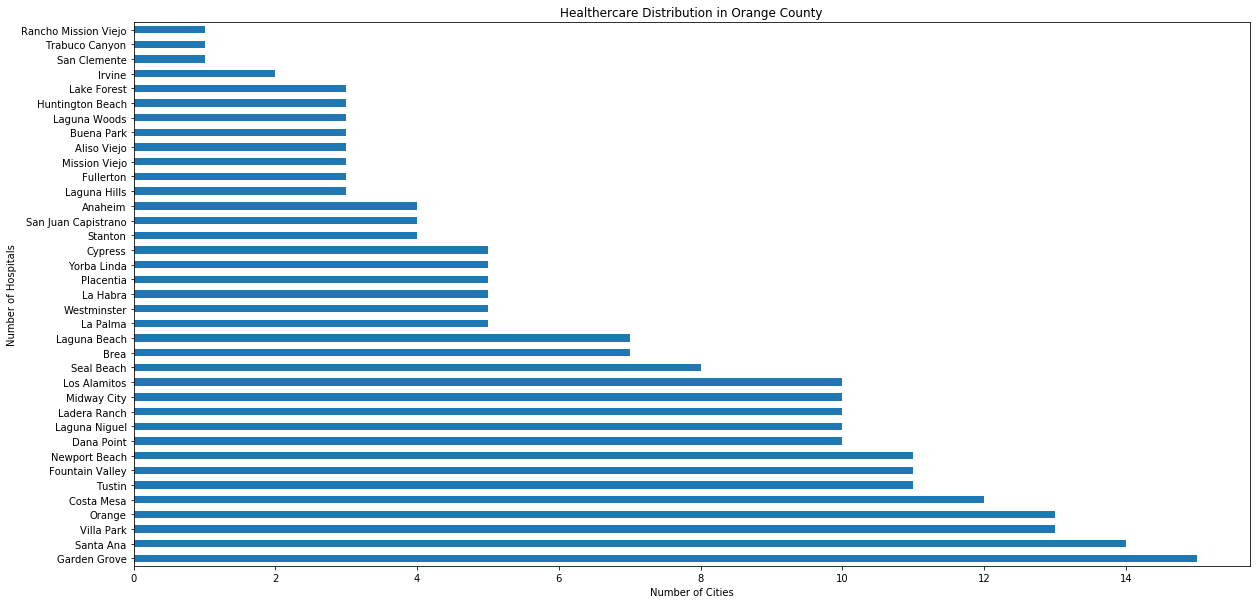

In [94]:
# Create bar chart to visualize the hospital distributions in Orange County
%matplotlib inline
import matplotlib as plt
from matplotlib import pyplot

city_name = local_hospitals['City'].value_counts().to_list()

local_hospitals['City'].value_counts().plot(kind='barh', figsize=(20,10))
plt.pyplot.title('Healthercare Distribution in Orange County') 
plt.pyplot.ylabel('Number of Hospitals')
plt.pyplot.xlabel('Number of Cities') 

plt.pyplot.show()

In [95]:
hos_map = folium.Map(location=[irvine_lat, irvine_lng], zoom_start=11)

# add markers to map
for lat, lng, label in zip(local_hospitals['Hospital Latitude'], 
                           local_hospitals['Hospital Longitude'], 
                           local_hospitals['Hospital']):
    
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(hos_map)  
    
hos_map

In [96]:
# Create a new dataframe by merging the two tables 
# One for city total cases and one for local hospitals, for K-means clustering

df_merged = df.join(local_hospitals.set_index(['City', 'City Latitude', 'City Longitude']), 
                    on = ['City', 'City Latitude', 'City Longitude'])
df_merged = df_merged.reset_index(drop = True)
df_merged.head()

,City,Total Cases,City Latitude,City Longitude,Hospital,Hospital Latitude,Hospital Longitude,Categories
0,Aliso Viejo,18,33.56964,-117.72691,Mission Hospital - Cardiac Telemetry,33.569755,-117.709308,Hospital
1,Aliso Viejo,18,33.56964,-117.72691,Mission Hospital O. R.,33.594256,-117.700358,Hospital
2,Aliso Viejo,18,33.56964,-117.72691,Saddleback Memorial Medical Center,33.608810,-117.709162,Hospital
3,Anaheim,316,33.83286,-117.91524,AHMC Anaheim Regional Medical Tower,33.847422,-117.934507,Hospital
4,Anaheim,316,33.83286,-117.91524,AHMC Anaheim Regional Medical Center,33.848175,-117.934526,Hospital


In [97]:
# Let's create a new dataframe that only contains numerical information
df1 = df_merged.drop(['Hospital Latitude', 'Hospital Longitude', 'Hospital', 'Categories'], 1). drop_duplicates()

# Reorder our new dataframe and show the number of hospitals accordingly
df_new = pd.merge(df1, df_hos, on='City')

print(df_new.shape)
df_new.head()

(37, 5)


,City,Total Cases,City Latitude,City Longitude,Number of Hospitals
0,Aliso Viejo,18,33.56964,-117.72691,3
1,Anaheim,316,33.83286,-117.91524,4
2,Brea,20,33.91759,-117.88899,7
3,Buena Park,76,33.86520,-117.99804,3
4,Costa Mesa,38,33.66389,-117.90239,12


In [98]:
# Change "Total Cases" column type to integer
df_new['Total Cases'] = df_new['Total Cases'].astype(int)
df_new.dtypes

# Add another column called "Harship Index" which measure if healthcare system in each
# city is overwhelmed. It is calculated as, Total Cases/Number of Hospitals, columns are normalized
# Higher the "Hardship Index", worse the healthcare system is handling, thus reaching its healthcare maximun capacity

# First we normalize the inputs

df_new['Total_z'] = (df_new['Total Cases'] - df_new['Total Cases'].mean())/df_new['Total Cases'].std(ddof=0)
df_new['Hospitals_z'] = (df_new['Number of Hospitals'] - df_new['Number of Hospitals'].mean())/df_new['Number of Hospitals'].std(ddof=0)

df_new['Hardship Index'] = df_new['Total_z']/df_new['Hospitals_z']

print(df_new.shape)
df_new.head()

(37, 8)


,City,Total Cases,City Latitude,City Longitude,Number of Hospitals,Total_z,Hospitals_z,Hardship Index
0,Aliso Viejo,18,33.56964,-117.72691,3,-0.538150,-0.879297,0.612023
1,Anaheim,316,33.83286,-117.91524,4,3.441491,-0.632827,-5.438279
2,Brea,20,33.91759,-117.88899,7,-0.511441,0.106581,-4.798597
3,Buena Park,76,33.86520,-117.99804,3,0.236411,-0.879297,-0.268863
4,Costa Mesa,38,33.66389,-117.90239,12,-0.271060,1.338929,-0.202446


## 10. Cluster and Visualize the Healthcare Hardship

According to Hardship Index, we now can cluster cities into different catagories.

In [99]:
# Generate 3 clusters by categorizing total cases
clusters = np.linspace(min(df_new['Hardship Index']), max(df_new['Hardship Index']), 4)

# Cluster into groups
cluster_names = ['1', '2', '3']
df_new['Healthcare Capacity'] = pd.cut(df_new['Hardship Index'], clusters, labels=cluster_names, include_lowest=True )
df_new.head()

,City,Total Cases,City Latitude,City Longitude,Number of Hospitals,Total_z,Hospitals_z,Hardship Index,Healthcare Capacity
0,Aliso Viejo,18,33.56964,-117.72691,3,-0.538150,-0.879297,0.612023,3
1,Anaheim,316,33.83286,-117.91524,4,3.441491,-0.632827,-5.438279,1
2,Brea,20,33.91759,-117.88899,7,-0.511441,0.106581,-4.798597,1
3,Buena Park,76,33.86520,-117.99804,3,0.236411,-0.879297,-0.268863,3
4,Costa Mesa,38,33.66389,-117.90239,12,-0.271060,1.338929,-0.202446,3


In [100]:
# Cluster 1: 
df_new[df_new['Healthcare Capacity'] == '1']

,City,Total Cases,City Latitude,City Longitude,Number of Hospitals,Total_z,Hospitals_z,Hardship Index,Healthcare Capacity
1,Anaheim,316,33.83286,-117.91524,4,3.441491,-0.632827,-5.438279,1
2,Brea,20,33.91759,-117.88899,7,-0.511441,0.106581,-4.798597,1


In [72]:
# Cluster 2: 
df_new[df_new['Healthcare Capacity'] == '2']

,City,Total Cases,City Latitude,City Longitude,Number of Hospitals,Total_z,Hospitals_z,Hardship Index,Healthcare Capacity
6,Dana Point,23,33.48054,-117.69765,10,-0.471378,0.845990,-0.557191,2
10,Huntington Beach,214,33.67893,-118.00157,3,2.079332,-0.879297,-2.364767,2
11,Irvine,126,33.68730,-117.82591,2,0.904136,-1.125766,-0.803129,2
14,Ladera Ranch,12,33.57046,-117.63927,10,-0.618277,0.845990,-0.730833,2
15,Laguna Beach,37,33.54536,-117.78153,7,-0.284415,0.106581,-2.668521,2
20,Los Alamitos,22,33.80316,-118.07662,10,-0.484732,0.845990,-0.572976,2
21,Midway City,6,33.74469,-117.98647,10,-0.698404,0.845990,-0.825547,2
30,Seal Beach,11,33.74256,-118.10517,8,-0.631632,0.353051,-1.789067,2


In [73]:
# Cluster 3: 
df_new[df_new['Healthcare Capacity'] == '3']

,City,Total Cases,City Latitude,City Longitude,Number of Hospitals,Total_z,Hospitals_z,Hardship Index,Healthcare Capacity
0,Aliso Viejo,18,33.56964,-117.72691,3,-0.538150,-0.879297,0.612023,3
3,Buena Park,76,33.86520,-117.99804,3,0.236411,-0.879297,-0.268863,3
4,Costa Mesa,38,33.66389,-117.90239,12,-0.271060,1.338929,-0.202446,3
5,Cypress,42,33.82434,-118.03723,5,-0.217642,-0.386358,0.563318,3
7,Fountain Valley,31,33.70907,-117.95028,11,-0.364542,1.092460,-0.333689,3
8,Fullerton,74,33.87033,-117.92896,3,0.209702,-0.879297,-0.238488,3
9,Garden Grove,99,33.77607,-117.93611,15,0.543564,2.078338,0.261538,3
12,La Habra,46,33.93187,-117.94348,5,-0.164224,-0.386358,0.425058,3
13,La Palma,14,33.84847,-118.03727,5,-0.591568,-0.386358,1.531142,3
16,Laguna Hills,20,33.60186,-117.69095,3,-0.511441,-0.879297,0.581648,3


## 11. Final Data Visualization

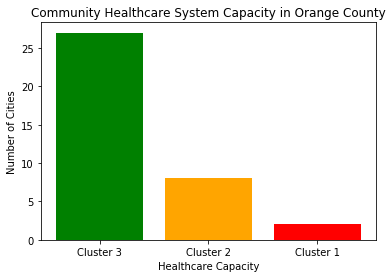

In [75]:
# Create bar chart to visualize the overal healthcare system capacity in Orange County
%matplotlib inline
import matplotlib as plt
from matplotlib import pyplot

pyplot.bar(['Cluster 3', 'Cluster 2', 'Cluster 1'], df_new["Healthcare Capacity"].value_counts(), color = ('g', 'orange', 'r'))


plt.pyplot.title('Community Healthcare System Capacity in Orange County') 
plt.pyplot.ylabel('Number of Cities')
plt.pyplot.xlabel('Healthcare Capacity') 

plt.pyplot.show()

In [109]:
df_new['Healthcare Capacity'] = df_new['Healthcare Capacity'].astype('category').cat.codes
df_new.dtypes

City                    object
Total Cases              int64
City Latitude          float64
City Longitude         float64
Number of Hospitals      int64
Total_z                float64
Hospitals_z            float64
Hardship Index         float64
Healthcare Capacity       int8
dtype: object

In [110]:
# Visualize three clusters on the map

map_clusters = folium.Map(location=[irvine_lat, irvine_lng], zoom_start=11)


# Set color scheme for the clusters
x = np.arange(4)
ys = [i + x + (i*x)**2 for i in range(4)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lng, cluster in zip(df_new['City Latitude'], df_new['City Longitude'], df_new['Healthcare Capacity']):
    #label = folium.Popup(str(city)+ ','+str(state) + '- Cluster ' + str(cluster), parse_html=True)
    folium.vector_layers.CircleMarker(
        [lat, lng],
        radius=5,
        #popup=label,
        tooltip = str(cluster),
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters